In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calendar

In [2]:
invoice = pd.read_csv('Invoices-1.csv')
Fuel_Level_1 = pd.read_csv('Fuel_Level_Part_1-1.csv')
Fuel_Level_2 = pd.read_csv('Fuel_Level_Part_2-1.csv')
Location = pd.read_csv('Locations-1.csv')
Tank = pd.read_csv('Tanks-1.csv')

# 1. Evaluate Current Inventory Management Practices
## Data Preprocessing

In [3]:
Fuel_Level_1.rename(columns={'Time stamp': 'Time', "Fuel_Level": "Fuel Level"}, inplace=True)
Fuel_Level_2.rename(columns={'Timestamp': 'Time', "Fuel_Level": "Fuel Level"}, inplace=True)

In [4]:
#Concatenate Fuel_Level_Part_1.csv and Fuel_Level_Part_2.csv
Fuel_Level = pd.concat([Fuel_Level_1, Fuel_Level_2]).sort_values(by='Time')
Fuel_Level

,Tank ID,Fuel Level,Time
0,T 32,22327.0,1/1/2017 0:05
805588,T 31,25730.0,1/1/2017 0:05
425740,T 21,14450.0,1/1/2017 0:07
1,T 20,25215.0,1/1/2017 0:07
2,T 10,25700.0,1/1/2017 0:09
...,...,...,...
599835,T 22,26726.0,9/9/2018 9:58
599836,T 14,28244.0,9/9/2018 9:58
138457,T 13,6485.0,9/9/2018 9:58
546862,T 23,27801.0,9/9/2018 9:58


In [5]:
#drop null values
invoice.dropna(inplace=True)
Tank.dropna(inplace=True)

In [6]:
#merge invoice & location
merged_data = invoice.merge(Location, left_on='Invoice Gas Station Location', right_on='Gas Station Location', how='left')
#merge Tank 
merged = Tank.merge(merged_data, left_on='Tank Location', right_on='Invoice Gas Station Location', how='left')

In [7]:
# clean & reorganize
merged = merged.drop(columns=['Invoice Gas Station Location', 'Tank Location']) 

In [8]:
column_order = [
    'Invoice Date', 'Invoice ID', 'Gas Station Location', 'Gas Station Name', 'Gas Station Address', 'Amount Purchased', 
    'Gross Purchase Cost', 'Fuel Type', 'Tank ID', 'Tank Number',  'Tank Type', 'Tank Capacity',
    'Gas Station Latitude', 'Gas Station Longitude'
]
merged = merged[column_order]

In [9]:
#make it into new file
merged.to_csv('merged.csv', index=False)

In [10]:
#make it into new file
Fuel_Level.to_csv('Fuel_Level.csv', index=False)

## 1.2 Visualize Fuel Levels


In [11]:
#convert data time
Fuel_Level['Time'] = pd.to_datetime(Fuel_Level['Time'], errors='coerce')
Fuel_Level['Week'] = Fuel_Level['Time'].dt.to_period('W').dt.start_time

In [12]:
# conver tank id into int
Fuel_Level['Tank ID'] = Fuel_Level['Tank ID'].str.replace('T ', '')
Fuel_Level['Tank ID'] = Fuel_Level['Tank ID'].str.replace('T', '')
Fuel_Level['Tank ID'] = Fuel_Level['Tank ID'].astype(int) 

In [13]:
#sort ascending
Fuel_Level = Fuel_Level.sort_values(by='Tank ID').reset_index(drop=True)

In [14]:
week = Fuel_Level.groupby(['Tank ID', 'Week'])['Fuel Level'].mean().reset_index()

In [15]:
#find tank id
uni_tank = Fuel_Level['Tank ID'].unique()

In [16]:
#set subplot form
num_cols = 4
num_rows = (len(uni_tank) + num_cols - 1) // num_cols  # Ceiling division

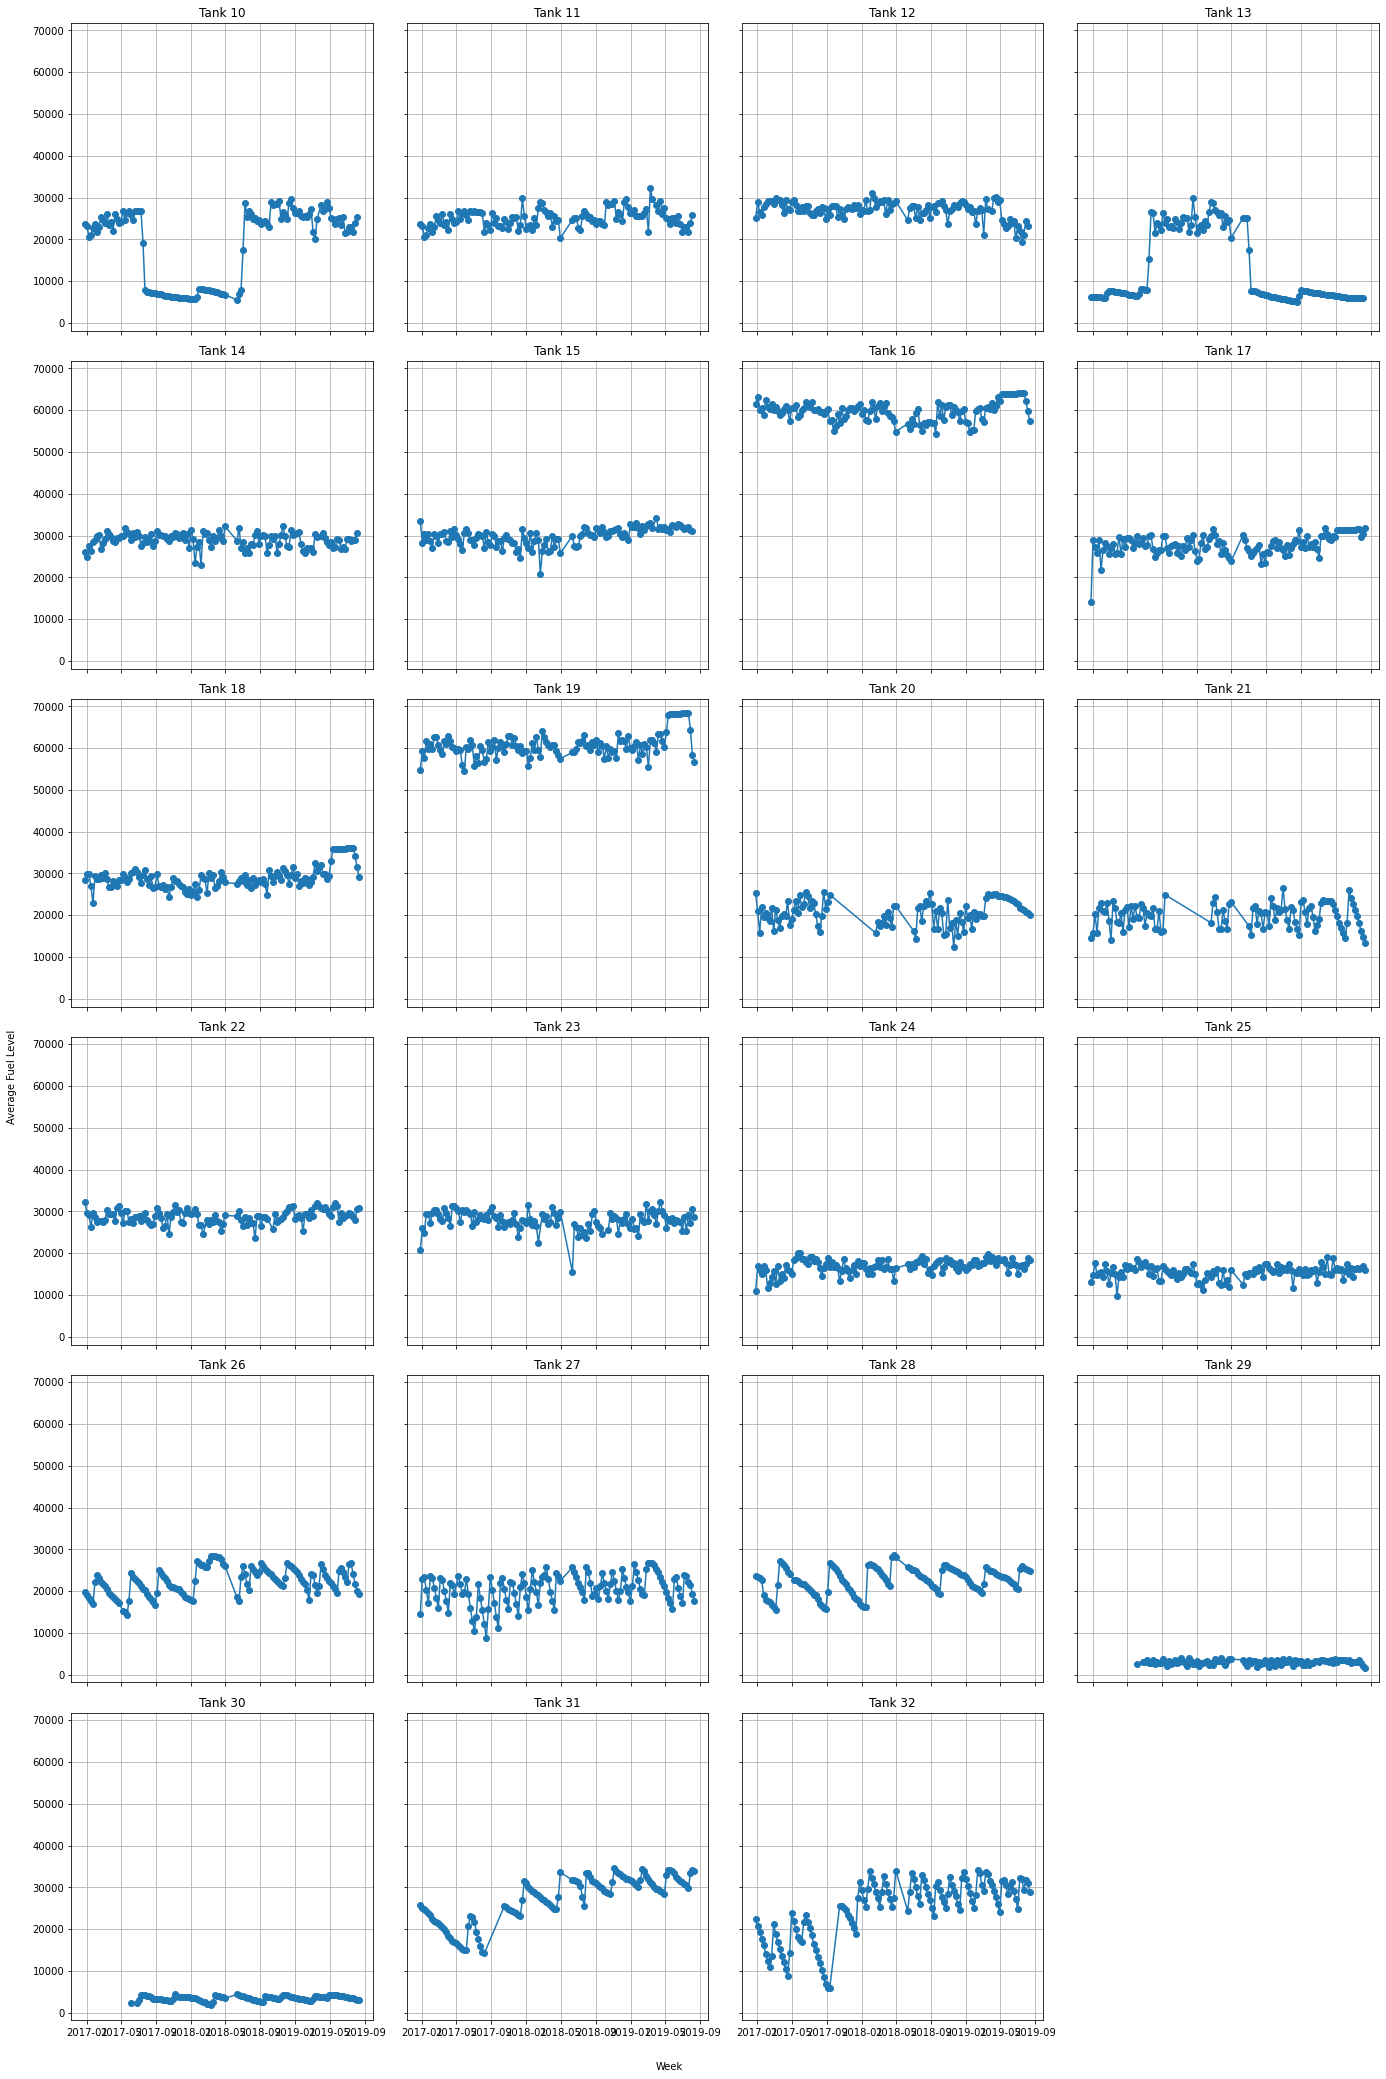

In [17]:
# Set up figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows), sharex=True, sharey=True)
axes = axes.flatten()

# Plot data for each tank
for i, tank in enumerate(uni_tank):
    ax = axes[i]
    tank_data = week[week['Tank ID'] == tank]
    ax.plot(tank_data['Week'], tank_data['Fuel Level'], marker='o', label=f'Tank {tank}')
    ax.set_title(f'Tank {tank}')
    ax.grid(True)

# Hide unused subplots
for i in range(len(uni_tank), len(axes)):
    axes[i].axis('off')

# Add common labels
fig.text(0.5, 0.04, 'Week', ha='center')
fig.text(0.04, 0.5, 'Average Fuel Level', va='center', rotation='vertical')
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.savefig(f'Fuel Levels by week.png')
plt.show()

### 1.2.1 risk of stockouts
Station 1: t 10-15; station 2: t16-19; station 3: t20-21; station 4: t22-23 ; station 5:24-25 ;station 6: 26,27,28; station 7: 29-30 ; station 8: 31-32
 - Station 1 is at risk of stockout. Tank 10 and Tank 13 have low inventory level in plenty of days.
 - Station 7 is at risk of stockout. Tank 29 and 30 has low inventory level in plenty of days.
 - Stations 3 and 6 have effective inventory management practices because they reduce purchasing costs by larger and less frequent deliveries. In addition, they maintain adequate fuel levels to avoid stockouts.

## 1.3 Quantify Current Performance

In [18]:
# Compute the discount by amount purchased
def compute_discount(quantity):
    if quantity < 15000:
        return 0
    if quantity < 25000:
        return 0.02 * quantity
    if quantity < 40000:
        return 0.03 * quantity
    return 0.04 * quantity
invoice['discount'] = invoice['Amount Purchased'].apply(compute_discount)

In [19]:
# Compute cost savings achieved via discounts
insum= invoice.groupby('Invoice Gas Station Location').agg({'discount': 'sum'})
#list
sorted_discounts = insum.sort_values(by='discount', ascending=False)
sorted_discounts

,discount
Invoice Gas Station Location,
1,190587.37552
2,10296.32160
3,1955.05056
6,1461.89504
8,1335.39648
4,343.36672
5,0.00000
7,0.00000


As the table show above, station 1 has the largest cost savings. Stations 5 and 7 have no cost savings because of small deliveries.

# 2. Recommend Improved Ordering Strategies
## Propose strategies to improve fuel order quantities and save costs.
### • Quantify Maximum Potential Savings:
####   Use the total tank capacity for each location and fuel type to determine the highest applicable discount rate.
####   Calculate a 7-day inventory threshold based on the average daily consumption for each location and fuel type.
####   Compute potential savings by optimizing order quantities to maximize discounts while maintaining sufficient inventory.
### • Provide Recommendations:
####   Offer specific recommendations to improve inventory policies and estimate potential cost savings for each location.

## 2.1 Quantify Maximum Potential Savings

In [20]:
# Read data
file = pd.read_csv("merged.csv")
fuel_level = pd.read_csv("Fuel_Level.csv")

In [21]:
file.head()

,Invoice Date,Invoice ID,Gas Station Location,Gas Station Name,Gas Station Address,Amount Purchased,Gross Purchase Cost,Fuel Type,Tank ID,Tank Number,Tank Type,Tank Capacity,Gas Station Latitude,Gas Station Longitude
0,1/2/2017,10000.0,1,EastMount,"386 Upper Gage Ave, Hamilton, ON L8V 4H9, Canada",6609.600,7570.82000,G,T 10,1,U,40000,43.23467,-79.83651
1,1/2/2017,10001.0,1,EastMount,"386 Upper Gage Ave, Hamilton, ON L8V 4H9, Canada",9338.736,12491.85300,D,T 10,1,U,40000,43.23467,-79.83651
2,1/3/2017,10006.0,1,EastMount,"386 Upper Gage Ave, Hamilton, ON L8V 4H9, Canada",4239.216,5670.54418,D,T 10,1,U,40000,43.23467,-79.83651
3,1/3/2017,10007.0,1,EastMount,"386 Upper Gage Ave, Hamilton, ON L8V 4H9, Canada",6659.184,7627.60115,G,T 10,1,U,40000,43.23467,-79.83651
4,1/3/2017,10008.0,1,EastMount,"386 Upper Gage Ave, Hamilton, ON L8V 4H9, Canada",26704.960,32175.98500,G,T 10,1,U,40000,43.23467,-79.83651


In [22]:
# Define the discount function
def discount(order):
    if order <= 15000:
        return 0
    elif order <= 25000:
        return 0.02
    elif order <= 40000:
        return 0.03
    else:
        return 0.04

In [23]:
capacity = file.groupby(['Gas Station Location','Fuel Type'])['Tank Capacity'].sum().reset_index()
capacity

,Gas Station Location,Fuel Type,Tank Capacity
0,1,D,143760000
1,1,G,182880000
2,2,D,76340000
3,2,G,62700000
4,3,D,2460000
5,3,G,2340000
6,4,D,14720000
7,4,G,13760000
8,5,D,6250000
9,5,G,7750000


In [24]:
# Determine the daily consumption of fuel
fuel_level['Time'] = pd.to_datetime(fuel_level['Time'])
fuel_level['Date'] = fuel_level['Time'].dt.date
daily_fuel_level = fuel_level.groupby(['Tank ID', 'Date'])['Fuel Level'].max().reset_index()
daily_fuel_level['Daily Consumption'] = daily_fuel_level.groupby('Tank ID')['Fuel Level'].diff(-1).abs()
consumption = daily_fuel_level.groupby(['Tank ID'])['Daily Consumption'].mean().reset_index()
consumption

,Tank ID,Daily Consumption
0,T 10,3013.968218
1,T 11,4700.422247
2,T 12,3809.098751
3,T 13,1723.101022
4,T 14,2997.319318
5,T 15,2329.715096
6,T 16,2417.352683
7,T 17,2829.380066
8,T 18,2153.670318
9,T 19,2281.687842


In [25]:
# Aggregate daily consumption by gas station and fuel type
fuel_level_station = file[['Tank ID', 'Gas Station Location', 'Fuel Type']].drop_duplicates()
consumption = consumption.merge(fuel_level_station, on = 'Tank ID')
consumption = consumption.groupby(['Gas Station Location', 'Fuel Type'])['Daily Consumption'].sum().reset_index()
consumption

,Gas Station Location,Fuel Type,Daily Consumption
0,1,D,18573.624653
1,1,G,18573.624653
2,2,D,9682.090909
3,2,G,9682.090909
4,3,D,1794.302650
5,3,G,1794.302650
6,4,D,4963.463636
7,4,G,4963.463636
8,5,D,3557.935307
9,5,G,3557.935307


In [26]:
# Calculate optimal order quantity based on 7-day threshold
consumption = consumption.merge(capacity, on = ['Gas Station Location','Fuel Type'])
consumption['Optimal Order Quantity'] = consumption['Daily Consumption'] * 7
consumption

,Gas Station Location,Fuel Type,Daily Consumption,Tank Capacity,Optimal Order Quantity
0,1,D,18573.624653,143760000,130015.372571
1,1,G,18573.624653,182880000,130015.372571
2,2,D,9682.090909,76340000,67774.636364
3,2,G,9682.090909,62700000,67774.636364
4,3,D,1794.302650,2460000,12560.118550
5,3,G,1794.302650,2340000,12560.118550
6,4,D,4963.463636,14720000,34744.245455
7,4,G,4963.463636,13760000,34744.245455
8,5,D,3557.935307,6250000,24905.547149
9,5,G,3557.935307,7750000,24905.547149


In [27]:
# Calculate potential savings
optimized = consumption[['Gas Station Location', 'Fuel Type', 'Optimal Order Quantity']].copy()
optimized['Optimal Discount Rate'] = optimized['Optimal Order Quantity'].apply(discount)
optimized['Potential Savings'] = optimized['Optimal Order Quantity'] * optimized['Optimal Discount Rate']
optimized['days'] = consumption['Tank Capacity'] / consumption['Daily Consumption']
optimized

,Gas Station Location,Fuel Type,Optimal Order Quantity,Optimal Discount Rate,Potential Savings,days
0,1,D,130015.372571,0.04,5200.614903,7740.007817
1,1,G,130015.372571,0.04,5200.614903,9846.220294
2,2,D,67774.636364,0.04,2710.985455,7884.660526
3,2,G,67774.636364,0.04,2710.985455,6475.873919
4,3,D,12560.118550,0.00,0.000000,1371.006168
5,3,G,12560.118550,0.00,0.000000,1304.127818
6,4,D,34744.245455,0.03,1042.327364,2965.670967
7,4,G,34744.245455,0.03,1042.327364,2772.257643
8,5,D,24905.547149,0.02,498.110943,1756.636774
9,5,G,24905.547149,0.02,498.110943,2178.229600


In [28]:
# Save the results
optimized.to_csv("optimized.csv", index=False)

## 2.2 Provide Recommendations

#### Stations with higher average consumption, such as Location 1 and 2, should maintain current inventory strategies, focusing on maximizing discounts by aligning order quantities with discount thresholds. 
#### Stations with lower consumption, such as 7 and 8, should extend their inventory cycle (from 7 days to 14 or 30 days) to simulate larger order volumes and qualify for discounts.
#### We can also combine purchases across nearby locations to simulate higher order quantities, for example stations 3 and 6, where individual orders fail to qualify for discounts, but their combined order quantity qualifies for a 0.02 discount rate.
#### The potential savings for each location is listed below: 
#### Location 1: 10401.2
#### Location 2: 5422.0
#### Location 3: 0.0
#### Location 4: 2084.6
#### Location 5: 996.2
#### Location 6: 0.0
#### Location 7: 0.0
#### Location 8: 0.0

# 3. Identify the Best Day for Fuel Orders

## 3.1 Examine the distribution of price-per-liter rates by day of the week

In [29]:
# Convert 'Invoice Date' to datetime format
file['Invoice Date'] = pd.to_datetime(file['Invoice Date'], errors='coerce')

# Compute the day of the week (0=Monday, 6=Sunday)
file['week_day'] = file['Invoice Date'].dt.dayofweek

# Compute the price per liter
file['price'] = file['Gross Purchase Cost'] / file['Amount Purchased']
file.head()

,Invoice Date,Invoice ID,Gas Station Location,Gas Station Name,Gas Station Address,Amount Purchased,Gross Purchase Cost,Fuel Type,Tank ID,Tank Number,Tank Type,Tank Capacity,Gas Station Latitude,Gas Station Longitude,week_day,price
0,2017-01-02,10000.0,1,EastMount,"386 Upper Gage Ave, Hamilton, ON L8V 4H9, Canada",6609.600,7570.82000,G,T 10,1,U,40000,43.23467,-79.83651,0,1.145428
1,2017-01-02,10001.0,1,EastMount,"386 Upper Gage Ave, Hamilton, ON L8V 4H9, Canada",9338.736,12491.85300,D,T 10,1,U,40000,43.23467,-79.83651,0,1.337639
2,2017-01-03,10006.0,1,EastMount,"386 Upper Gage Ave, Hamilton, ON L8V 4H9, Canada",4239.216,5670.54418,D,T 10,1,U,40000,43.23467,-79.83651,1,1.337640
3,2017-01-03,10007.0,1,EastMount,"386 Upper Gage Ave, Hamilton, ON L8V 4H9, Canada",6659.184,7627.60115,G,T 10,1,U,40000,43.23467,-79.83651,1,1.145426
4,2017-01-03,10008.0,1,EastMount,"386 Upper Gage Ave, Hamilton, ON L8V 4H9, Canada",26704.960,32175.98500,G,T 10,1,U,40000,43.23467,-79.83651,1,1.204869


No data available for Sunday.


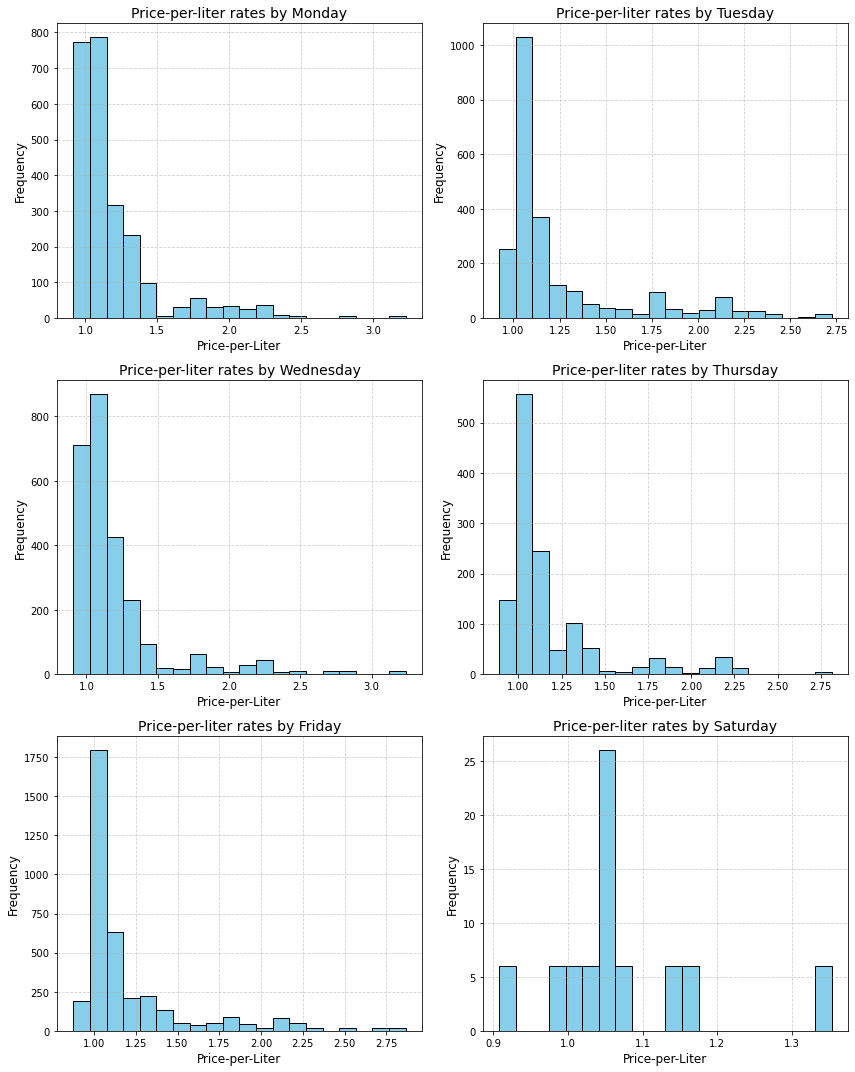

In [30]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15))  # For better data visualization
for day in range(7):
    df = file[file['week_day'] == day]
    
    if df.empty:
        print(f"No data available for {calendar.day_name[day]}.")
        continue

    ax = axs[day // 2, day % 2] 
    
    ax.hist(df['price'], bins=20, edgecolor='black', color='skyblue') 
    ax.set_title(f'Price-per-liter rates by {calendar.day_name[day]}', fontsize=14)
    ax.set_xlabel('Price-per-Liter', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6) 


plt.tight_layout()
plt.show()

### 3.1.1 Conclusion
The histograms show the distribution of price-per-liter rates across the days of the week, with Sunday missing due to insufficient data. Most price-per-liter rates fall between 1.00 and 1.40, indicating relatively stable prices. However, the data for Saturday is limited, likely due to fewer transactions on this non-workday, which could affect the accuracy of the results for that day. 

## 3.2 Identify the day with the lowest historical rates.

In [31]:
# Group by week_day and calculate mean price
mean_pricerates = file.groupby('week_day').agg({'price': 'mean'})

# Convert the 'week_day' index to day names
mean_pricerates['Day'] = mean_pricerates.index.map(lambda x: calendar.day_name[x])
mean_pricerates = mean_pricerates.set_index('Day')

# Print the mean price by day
print(mean_pricerates[['price']])

              price
Day                
Monday     1.194935
Tuesday    1.250105
Wednesday  1.203339
Thursday   1.192839
Friday     1.218674
Saturday   1.073266


In [32]:
# Find the day of the week with the lowest average price rate
lowest_avg_price_day = mean_pricerates['price'].idxmin()
print(f"The day of the week with the lowest average price is: {lowest_avg_price_day}")

The day of the week with the lowest average price is: Saturday


In [33]:
# Find the row with the lowest historical price
lowest_price_row = file.loc[file['price'].idxmin()]

# Get the specific date of that row
lowest_price_date = lowest_price_row['Invoice Date']

In [34]:
# Print the specific day with the lowest historical price
print(f"The specific day with the lowest historical price is: {lowest_price_date}")

The specific day with the lowest historical price is: 2017-06-16 00:00:00


### 3.2.1 Conclusion
Based on the average price rates, Saturday emerges as the best day to purchase fuel, with the lowest mean price across the week. However, when considering historical prices, the day with the absolute lowest price was June 16, 2017. This suggests that while trends on Saturdays are generally favorable, specific dates may still offer better prices, and historical data should be considered when making purchasing decisions. 

## 3.3 Calculate additional savings if purchases were consistently made on the identified day.

In [35]:
# Compute the amount purchased on each week day
cost_df = file.groupby('week_day').agg({'Amount Purchased': 'sum', 'Gross Purchase Cost': 'sum'})
# Keep rows from Monday - Friday
cost_df = cost_df.loc[:4]
cost_df

,Amount Purchased,Gross Purchase Cost
week_day,,
0,2.237326e+07,2.565686e+07
1,3.365399e+07,3.909907e+07
2,2.353579e+07,2.678979e+07
3,1.180115e+07,1.335587e+07
4,4.204078e+07,4.832907e+07


In [36]:
# Calculate the total cost if all purchases were made on Saturday
lowest_price = mean_pricerates['price'].idxmin()  # Saturday is the day with the lowest price
cost_df['Total Cost'] = cost_df['Amount Purchased'] * mean_pricerates.loc['Saturday', 'price']
cost_df

,Amount Purchased,Gross Purchase Cost,Total Cost
week_day,,,
0,2.237326e+07,2.565686e+07,2.401245e+07
1,3.365399e+07,3.909907e+07,3.611967e+07
2,2.353579e+07,2.678979e+07,2.526015e+07
3,1.180115e+07,1.335587e+07,1.266577e+07
4,4.204078e+07,4.832907e+07,4.512092e+07


In [37]:
# Compute the additional savings
savings = (cost_df['Gross Purchase Cost'] - cost_df['Total Cost']).sum()

# Print the additional savings
print('The additional savings are %.2f C$.' % savings)

The additional savings are 10051697.44 C$.


### 3.3.1 Conclusion
If fuel purchases were consistently made on the day with the lowest price (Saturday), the additional savings could reach over 10 million dollars. This highlights the potential for substantial cost reductions if consumers or businesses adapt their purchasing habits to take advantage of the lowest price days. The significant savings suggest that timing purchases for optimal days could lead to considerable financial benefits, emphasizing the importance of monitoring price trends and strategically planning fuel purchases.

# 4. Evaluate the Feasibility of Adding Tanks

### 4.1 Load the datasets

In [39]:

locations_path = 'Locations-1.csv'
tanks_path = 'Tanks-1.csv'
invoices_path = 'Invoices-1.csv'
fuel_part_1_path = 'Fuel_Level_Part_1-1.csv'
fuel_part_2_path = 'Fuel_Level_Part_2-1.csv'

locations = pd.read_csv(locations_path)
tanks = pd.read_csv(tanks_path)
invoices = pd.read_csv(invoices_path)
fuel_part_1 = pd.read_csv(fuel_part_1_path)
fuel_part_2 = pd.read_csv(fuel_part_2_path)

### 4.2 Standardize column names before merging

In [40]:

fuel_part_1.rename(columns={"Fuel Level": "Fuel_Level", "Time stamp": "Timestamp"}, inplace=True)
fuel_part_2.rename(columns={"Fuel Level": "Fuel_Level", "Time stamp": "Timestamp"}, inplace=True)

### 4.2.1 Combine the fuel level datasets

In [41]:

fuel_levels = pd.concat([fuel_part_1, fuel_part_2], ignore_index=True)

### 4.3 Merge datasets to create a unified dataset

In [42]:

tanks_merged = tanks.merge(locations, left_on="Tank Location", right_on="Gas Station Location", how="left")
fuel_levels_merged = fuel_levels.merge(tanks_merged, on="Tank ID", how="left")
invoices_merged = invoices.merge(locations, left_on="Invoice Gas Station Location", right_on="Gas Station Location", how="left")


In [43]:
print(fuel_levels)

        Tank ID  Fuel_Level        Timestamp
0          T 12     27161.0    1/1/2017 0:10
1          T 12     27017.0    1/1/2017 0:25
2          T 12     26934.0    1/1/2017 0:40
3           T12         NaN    1/1/2017 0:45
4          T 12     26786.0    1/1/2017 0:55
...         ...         ...              ...
1859655    T 32     27619.0  8/15/2019 23:53
1859656    T 22     31548.0  8/15/2019 23:57
1859657    T 16     53492.0  8/15/2019 23:57
1859658    T 18     27081.0  8/15/2019 23:57
1859659    T 25     11815.0  8/15/2019 23:59

[1859660 rows x 3 columns]


### 4.4 Feasibility calculations

In [44]:
# Merge datasets to create a unified dataset
tanks_merged = tanks.merge(locations, left_on="Tank Location", right_on="Gas Station Location", how="left")
fuel_levels_merged = fuel_levels.merge(tanks_merged, on="Tank ID", how="left")
invoices_merged = invoices.merge(locations, left_on="Invoice Gas Station Location", right_on="Gas Station Location", how="left")

# Calculate daily fuel consumption from invoices
invoices_merged['Invoice Date'] = pd.to_datetime(invoices_merged['Invoice Date'])

# Group by location and calculate daily consumption per fuel type
daily_consumption = invoices_merged.groupby(['Gas Station Location', 'Fuel Type', 'Invoice Date']) \
    .agg({'Amount Purchased': 'sum'}) \
    .groupby(['Gas Station Location', 'Fuel Type']) \
    .mean()

daily_consumption = daily_consumption.rename(columns={'Amount Purchased': 'Avg Daily Consumption (liters)'}).reset_index()

# Merge daily consumption data with tank capacities
tank_capacity = tanks.groupby(['Tank Location', 'Tank Type']).agg({'Tank Capacity': 'sum'}).reset_index()
tank_capacity = tank_capacity.rename(columns={'Tank Location': 'Gas Station Location', 'Tank Type': 'Fuel Type'})

# Combine tank capacity and consumption data
capacity_vs_consumption = pd.merge(daily_consumption, tank_capacity, on=['Gas Station Location', 'Fuel Type'], how='left')

# Add a column to calculate whether current capacity is constrained
capacity_vs_consumption['Days of Storage'] = capacity_vs_consumption['Tank Capacity'] / capacity_vs_consumption['Avg Daily Consumption (liters)']

# Fill missing tank capacities with a default or estimated value
capacity_vs_consumption['Tank Capacity'] = capacity_vs_consumption['Tank Capacity'].fillna(40000)  # Assuming default capacity

# Recalculate Days of Storage for filled values
capacity_vs_consumption['Days of Storage'] = capacity_vs_consumption['Tank Capacity'] / capacity_vs_consumption['Avg Daily Consumption (liters)']

# Sort by locations with least storage days
capacity_vs_consumption = capacity_vs_consumption.sort_values(by='Days of Storage')

# Function to calculate potential savings based on increased capacity
# Include the discount rate in the calculation
def calculate_discount_savings(amount_purchased):
    if amount_purchased > 40000:
        discount_rate = 0.04
    elif amount_purchased > 25000:
        discount_rate = 0.03
    elif amount_purchased > 15000:
        discount_rate = 0.02
    else:
        discount_rate = 0.00
    return amount_purchased * discount_rate

# Add a column for potential savings based on increased capacity
def calculate_discount_savings_for_capacity(row):
    current_savings = calculate_discount_savings(row['Avg Daily Consumption (liters)'] * row['Days of Storage'])
    
    # Simulate doubling capacity
    new_capacity = row['Tank Capacity'] * 2
    new_days_of_storage = new_capacity / row['Avg Daily Consumption (liters)']
    new_savings = calculate_discount_savings(row['Avg Daily Consumption (liters)'] * new_days_of_storage)
    
    return new_savings - current_savings

capacity_vs_consumption['Potential Savings (per order)'] = capacity_vs_consumption.apply(calculate_discount_savings_for_capacity, axis=1)

# Project savings over a 5-year period (assume 365 days/year, orders every current "Days of Storage")
def project_5_year_savings(row):
    if np.isnan(row['Tank Capacity']):
        return np.nan
    
    current_orders_per_year = 365 / row['Days of Storage']
    
    # Simulate doubling capacity
    new_days_of_storage = row['Days of Storage'] * 2
    new_orders_per_year = 365 / new_days_of_storage

    current_savings = current_orders_per_year * row['Potential Savings (per order)']
    new_savings = new_orders_per_year * row['Potential Savings (per order)']

    return (new_savings - current_savings) * 5  # 5 years of savings

capacity_vs_consumption['5-Year Projected Savings'] = \
    capacity_vs_consumption.apply(project_5_year_savings, axis=1)

# Calculate inflation-adjusted cost of adding a tank
def inflation_adjusted_cost(initial_cost, years, inflation_rate):
    return initial_cost * ((1 + inflation_rate) ** years)

cost_per_tank = 50000
inflation_rate = 0.03
adjusted_cost = inflation_adjusted_cost(cost_per_tank, 5, inflation_rate)

# Calculate ROI (savings/cost)
capacity_vs_consumption['ROI'] = capacity_vs_consumption['5-Year Projected Savings'] / adjusted_cost

# Rank locations by ROI
capacity_vs_consumption['Rank'] = capacity_vs_consumption['ROI'].rank(ascending=False)

# Display the ranked recommendations
print("Tank Expansion Recommendations")
print(capacity_vs_consumption)

capacity_vs_consumption


Tank Expansion Recommendations
    Gas Station Location Fuel Type  Avg Daily Consumption (liters)  \
1                    1.0         G                    20272.782119   
3                    2.0         G                    17210.449854   
4                    3.0         D                    10532.076098   
11                   6.0         G                    12889.336533   
12                   7.0         D                     1385.284000   
15                   8.0         G                    10933.816421   
5                    3.0         G                    10859.452718   
10                   6.0         D                     7804.278857   
8                    5.0         D                     6493.871616   
7                    4.0         G                     9178.010326   
6                    4.0         D                     8920.592525   
9                    5.0         G                     8744.888416   
14                   8.0         D                     8450

,Gas Station Location,Fuel Type,Avg Daily Consumption (liters),Tank Capacity,Days of Storage,Potential Savings (per order),5-Year Projected Savings,ROI,Rank
1,1.0,G,20272.782119,40000.0,1.973089,2000.0,-924945.684198,-15.957325,16.0
3,2.0,G,17210.449854,40000.0,2.324169,2000.0,-785226.774573,-13.546870,15.0
4,3.0,D,10532.076098,30000.0,2.848441,1500.0,-480525.971951,-8.290118,10.0
11,6.0,G,12889.336533,40000.0,3.103340,2000.0,-588075.979333,-10.145590,14.0
12,7.0,D,1385.284000,5000.0,3.609368,0.0,0.000000,0.000000,1.0
15,8.0,G,10933.816421,40000.0,3.658375,2000.0,-498855.374211,-8.606341,12.0
5,3.0,G,10859.452718,40000.0,3.683427,2000.0,-495462.530256,-8.547807,11.0
10,6.0,D,7804.278857,30000.0,3.844045,1500.0,-356070.222857,-6.142986,4.0
8,5.0,D,6493.871616,25000.0,3.849784,1500.0,-355539.470976,-6.133829,3.0
7,4.0,G,9178.010326,40000.0,4.358243,2000.0,-418746.721105,-7.224292,9.0


-The majority of locations show negative ROI, indicating that the cost of adding a tank outweighs the projected savings over 5 years. 

-The discount rates, even at maximum thresholds, do not lead to meaningful financial benefits when capacity is doubled. 

-Station 7.0 D shows the lowest potential savings and is ranked 1. However, its projected savings are still zero due to its low daily consumption, making tank expansion unnecessary. 

-Stations with Minimal Savings (e.g., 3.0 D, 6.0 G) highlight that current consumption and storage dynamics do not justify expansion.

Recommendations: 


Avoid Tank Expansions at Current Costs:

-Given the consistent negative ROI, tank expansions under the current parameters are not financially feasible.

Focus on Operational Efficiency:

-Optimize fuel delivery schedules to balance storage capacity and bulk purchase discounts without incurring additional tank costs.

Reassess Costs and Incentives:

-Reevaluate tank installation costs and explore alternative supplier incentives or discount structures.
